In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import geoplot
import plotly_express as px
import calendar
import dataframe_image as dfi
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.svm import SVC

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

SEED = 456
#TEST = 0.2
PATH = ""

In [2]:
X_train = pd.read_csv(PATH + "Data/X_train_restaurants.csv", index_col = [0])
X_test = pd.read_csv(PATH + "Data/X_test_restaurants.csv", index_col = [0])
y_train = pd.read_csv(PATH + "Data/y_train_restaurants.csv", index_col = [0])
y_test = pd.read_csv(PATH + "Data/y_test_restaurants.csv", index_col = [0])

In [3]:
X_train

,BORO,CUISINE DESCRIPTION,VIOLATION DESCRIPTION,INSPECTION TYPE,Latitude,Longitude,INSPECTION PURPOSE,POST COVID,CRITICAL FLAGS PER INSPECTION,VIOLATIONS PER INSPECTION,TOTAL INSPECTIONS,RISKY BUSINESS,MONTHS OPERATING,YEAR,MONTH,DAY
0,Bronx,Bakery Products/Desserts,"Sanitized equipment or utensil, including in-u...",Cycle,40.848231,-73.855972,Initial,1,1,1,3,0,17,2021,8,10
1,Brooklyn,Other,"Food contact surface not properly washed, rins...",Cycle,40.662652,-73.962081,Initial,1,2,2,3,0,11,2021,7,20
2,Brooklyn,American,"Food contact surface not properly washed, rins...",Cycle,40.579920,-73.982090,Initial,0,1,3,2,0,26,2019,11,8
3,Brooklyn,Other,Facility not vermin proof. Harborage or condit...,Cycle,40.640795,-73.948488,Initial,1,1,3,2,0,16,2021,8,20
4,Brooklyn,Other,"Food contact surface not properly washed, rins...",Cycle,40.575537,-73.981652,Initial,1,1,3,2,0,14,2022,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16477,Brooklyn,Other,Cold TCS food item held above 41 °F; smoked or...,Pre-permit,40.700528,-73.921368,Initial,1,4,7,1,0,0,2023,5,31
16478,Bronx,Other,Non-food contact surface or equipment made of ...,Pre-permit,40.832998,-73.885099,Initial,1,0,1,1,0,0,2023,5,30
16479,Manhattan,Other,Non-food contact surface or equipment made of ...,Pre-permit,40.706374,-74.002882,Initial,1,0,1,1,0,0,2023,5,23
16480,Queens,Other,Non-food contact surface or equipment made of ...,Pre-permit,40.770867,-73.908461,Initial,1,1,3,1,0,0,2023,5,26


## Visualizations

/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_30944/4100868912.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


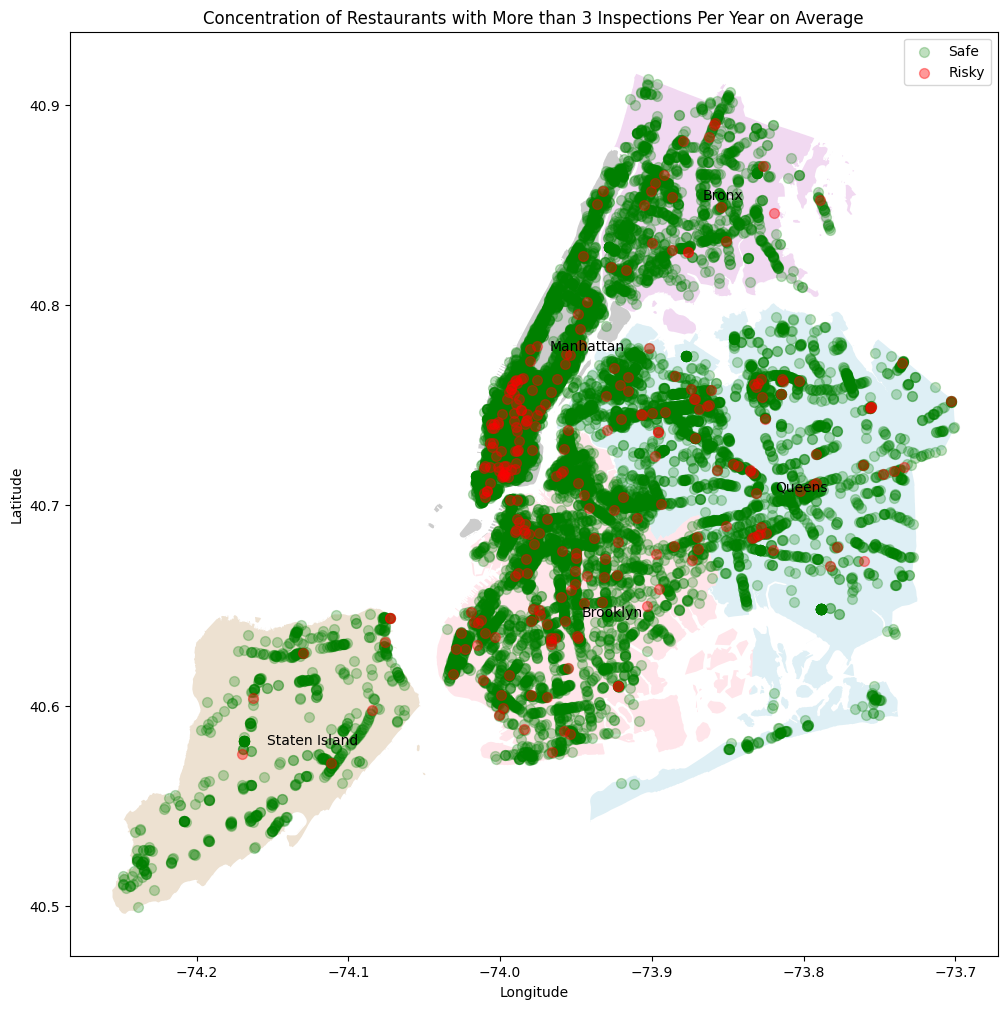

In [4]:
# map of risk by borough

crs = {'init':'epsg:4326'}

boroughs = geopandas.read_file(geoplot.datasets.get_path("nyc_boroughs"))

geo_df = geopandas.GeoDataFrame(X_train, crs = crs, geometry = geopandas.points_from_xy(X_train["Longitude"], 
                                                                                        X_train["Latitude"]))

fig, ax = plt.subplots(figsize = (12, 12))
boroughs.plot(ax = ax, alpha = 0.4, color = ["tan", "lightblue", "pink", "grey", "plum"], label = boroughs.BoroName)
boroughs.apply(lambda x: ax.annotate(text = x["BoroName"], xy = x.geometry.centroid.coords[0]), axis = 1)
geo_df[geo_df["RISKY BUSINESS"] == 0].plot(ax = ax, markersize = 50, alpha = 0.25, color = "green", label = "Safe")
geo_df[geo_df["RISKY BUSINESS"] != 0].plot(ax = ax, markersize = 50, alpha = 0.4, color = "red", label = "Risky")
plt.title("Concentration of Restaurants with More than 3 Inspections Per Year on Average")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.legend()
plt.show()

#plt.savefig(PATH + "Results/risk map.png")

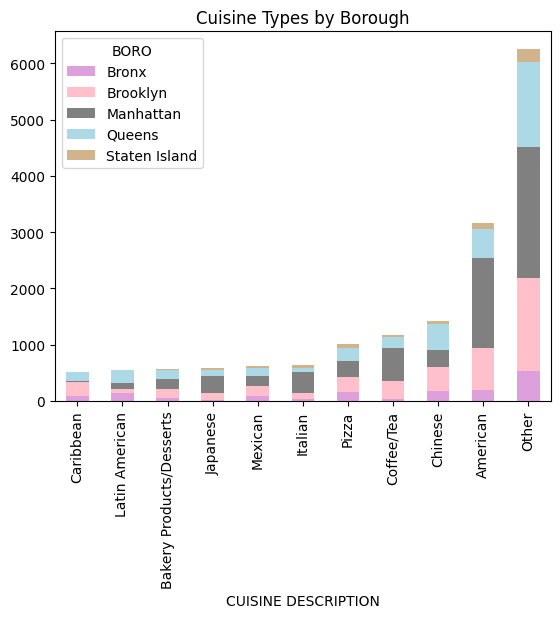

In [5]:
sorted_cuisines = pd.crosstab(X_train["CUISINE DESCRIPTION"], X_train["BORO"])
sorted_cuisines["Sum"] = sorted_cuisines.sum(axis = 1)
sorted_cuisines = sorted_cuisines.sort_values(by = "Sum")
sorted_cuisines = sorted_cuisines.drop("Sum", axis = 1)
sorted_cuisines.plot(kind = "bar", stacked = True, color = ["plum", "pink", "grey", "lightblue", "tan"])
plt.title("Cuisine Types by Borough")
plt.show()

#plt.savefig(PATH + "Results/borough cuisines.png")

In [6]:
inspections_overtime = pd.crosstab(X_train["MONTHS OPERATING"], X_train["TOTAL INSPECTIONS"])

def highlight(val, df = X_train):
    lim = np.ceil(df.shape[0] * 0.05)
    sig = lim / 5
    if val >= lim:
        return "background-color: blue"
    elif val >= sig:
        return "color: blue"
    
inspections_overtime = inspections_overtime.style.applymap(highlight)
inspections_overtime

#dfi.export(inspections_overtime, PATH + "Results/inspection table.png")

TOTAL INSPECTIONS,1,2,3,4,5,6,7,8,9,10,12,15
MONTHS OPERATING,,,,,,,,,,,,
0,2712,373,17,0,0,0,0,0,0,0,0,0
1,0,218,37,7,1,0,0,0,0,0,0,0
2,0,140,16,5,2,0,0,0,0,0,0,0
3,0,113,21,4,2,0,0,0,0,0,0,0
4,0,101,18,3,1,0,0,0,0,0,0,0
5,0,173,25,5,2,0,0,0,0,0,0,0
6,0,347,54,18,3,0,0,0,0,0,0,0
7,0,384,46,22,7,2,0,0,0,0,0,0
8,0,285,40,22,3,0,0,0,0,0,0,0


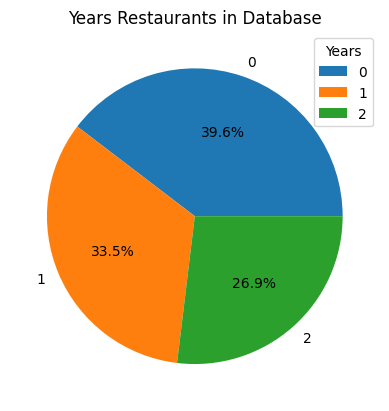

In [7]:
X_train["YEARS"] = X_train["MONTHS OPERATING"]//12

plt.pie(X_train["YEARS"].value_counts().values, labels = X_train["YEARS"].value_counts().index, autopct= '%.1f%%')
plt.legend(title = "Years")
plt.title("Years Restaurants in Database")
plt.show()

#plt.savefig(PATH + "Results/years in data.png")

In [8]:
X_train["POST COVID"].value_counts()

POST COVID
1    11850
0     4632
Name: count, dtype: int64

In [9]:
#x = X_train["MONTH"], y = X_train["VIOLATIONS PER INSPECTION"]
# Treemap of month: sized by violations per month (total), then broken down by crit and non crit violations
flags = X_train.groupby(["MONTH", "POST COVID"]).sum()[["CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]]
flags = flags.reset_index()
flags.MONTH = flags.MONTH.apply(lambda x: calendar.month_name[x])
flags = flags.replace({0:"Pre Covid", 1:"Post Covid"})
flags["PERCENT CRITICAL"] = np.round(flags["CRITICAL FLAGS PER INSPECTION"]/
                                     flags["VIOLATIONS PER INSPECTION"]*100, 2).astype("str")+"%"

#flags[["CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]] = 
#np.round(flags[["CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]] / 
#         flags[["CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION"]].sum() * 100, 2)

violation_treemap = px.treemap(flags, path = [px.Constant("Month"), "MONTH", "POST COVID", 
                                              "VIOLATIONS PER INSPECTION", "PERCENT CRITICAL"], 
                                              title = "Monthly Violations Pre and Post Covid")
#values = "VIOLATIONS PER INSPECTION", 
violation_treemap.update_layout(annotations = [(dict(x = 0.5, y = -0.05, showarrow = False, 
                                                     text = "*Percentage = Percentage of Violations Labeled Critical"))])

#violation_treemap.write_image(file = PATH + "Results/covid effect on violations.png", format = "png")
# not used for altered formatting (lose critical flag count) - saved manually

In [10]:
X_train = X_train.drop(["VIOLATION DESCRIPTION", "Latitude", "Longitude"], axis = 1)
X_test = X_test.drop(["VIOLATION DESCRIPTION", "Latitude", "Longitude"], axis = 1)

cols = ['BORO', 'CUISINE DESCRIPTION','INSPECTION TYPE', 'INSPECTION PURPOSE']
X_train = pd.get_dummies(X_train, columns = cols)
X_test = pd.get_dummies(X_test, columns = cols)

X_train

,POST COVID,CRITICAL FLAGS PER INSPECTION,VIOLATIONS PER INSPECTION,TOTAL INSPECTIONS,RISKY BUSINESS,MONTHS OPERATING,YEAR,MONTH,DAY,YEARS,...,CUISINE DESCRIPTION_Mexican,CUISINE DESCRIPTION_Other,CUISINE DESCRIPTION_Pizza,INSPECTION TYPE_Cycle,INSPECTION TYPE_Inter-Agency,INSPECTION TYPE_Pre-permit,INSPECTION PURPOSE_Compliance,INSPECTION PURPOSE_Initial,INSPECTION PURPOSE_Re-inspection,INSPECTION PURPOSE_Reopening
0,1,1,1,3,0,17,2021,8,10,1,...,False,False,False,True,False,False,False,True,False,False
1,1,2,2,3,0,11,2021,7,20,0,...,False,True,False,True,False,False,False,True,False,False
2,0,1,3,2,0,26,2019,11,8,2,...,False,False,False,True,False,False,False,True,False,False
3,1,1,3,2,0,16,2021,8,20,1,...,False,True,False,True,False,False,False,True,False,False
4,1,1,3,2,0,14,2022,2,10,1,...,False,True,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16477,1,4,7,1,0,0,2023,5,31,0,...,False,True,False,False,False,True,False,True,False,False
16478,1,0,1,1,0,0,2023,5,30,0,...,False,True,False,False,False,True,False,True,False,False
16479,1,0,1,1,0,0,2023,5,23,0,...,False,True,False,False,False,True,False,True,False,False
16480,1,1,3,1,0,0,2023,5,26,0,...,False,True,False,False,False,True,False,True,False,False


In [11]:
X_train.columns

Index(['POST COVID', 'CRITICAL FLAGS PER INSPECTION',
       'VIOLATIONS PER INSPECTION', 'TOTAL INSPECTIONS', 'RISKY BUSINESS',
       'MONTHS OPERATING', 'YEAR', 'MONTH', 'DAY', 'YEARS', 'BORO_Bronx',
       'BORO_Brooklyn', 'BORO_Manhattan', 'BORO_Queens', 'BORO_Staten Island',
       'CUISINE DESCRIPTION_American',
       'CUISINE DESCRIPTION_Bakery Products/Desserts',
       'CUISINE DESCRIPTION_Caribbean', 'CUISINE DESCRIPTION_Chinese',
       'CUISINE DESCRIPTION_Coffee/Tea', 'CUISINE DESCRIPTION_Italian',
       'CUISINE DESCRIPTION_Japanese', 'CUISINE DESCRIPTION_Latin American',
       'CUISINE DESCRIPTION_Mexican', 'CUISINE DESCRIPTION_Other',
       'CUISINE DESCRIPTION_Pizza', 'INSPECTION TYPE_Cycle',
       'INSPECTION TYPE_Inter-Agency', 'INSPECTION TYPE_Pre-permit',
       'INSPECTION PURPOSE_Compliance', 'INSPECTION PURPOSE_Initial',
       'INSPECTION PURPOSE_Re-inspection', 'INSPECTION PURPOSE_Reopening'],
      dtype='object')

In [12]:
np.where(X_train.corr() > 0.9)

# only on diagonals (autocorrelation)

(array([ 0,  1,  2,  3,  4,  5,  5,  6,  7,  8,  9,  9, 10, 11, 12, 13, 14,
        15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32]),
 array([ 0,  1,  2,  3,  4,  5,  9,  6,  7,  8,  5,  9, 10, 11, 12, 13, 14,
        15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32]))

## Resampling

In [13]:
print(y_train["GRADE"].value_counts())
y_train["GRADE"].value_counts().values/len(X_train)*100

# B and C unbalanced - generate synthetic samples with SMOTE/ADASYN
# (risky because would need to generate more instances than exist currectly)
# OR
# undersample A (down to 5000 - 6000)
# resampling vs class weights

GRADE
A    10061
B     3678
C     2743
Name: count, dtype: int64


array([61.04234923, 22.315253  , 16.64239777])

In [14]:
# ADASYN oversampling for class B and C
# - over and undersample to reduce likeihood of duplication

samples = {'B':5000, 'C':5000}
resamp = ADASYN(sampling_strategy = samples, random_state = SEED)
X_resample, y_resample = resamp.fit_resample(X_train, y_train)
X_resample

,POST COVID,CRITICAL FLAGS PER INSPECTION,VIOLATIONS PER INSPECTION,TOTAL INSPECTIONS,RISKY BUSINESS,MONTHS OPERATING,YEAR,MONTH,DAY,YEARS,...,CUISINE DESCRIPTION_Mexican,CUISINE DESCRIPTION_Other,CUISINE DESCRIPTION_Pizza,INSPECTION TYPE_Cycle,INSPECTION TYPE_Inter-Agency,INSPECTION TYPE_Pre-permit,INSPECTION PURPOSE_Compliance,INSPECTION PURPOSE_Initial,INSPECTION PURPOSE_Re-inspection,INSPECTION PURPOSE_Reopening
0,1,1,1,3,0,17,2021,8,10,1,...,False,False,False,True,False,False,False,True,False,False
1,1,2,2,3,0,11,2021,7,20,0,...,False,True,False,True,False,False,False,True,False,False
2,0,1,3,2,0,26,2019,11,8,2,...,False,False,False,True,False,False,False,True,False,False
3,1,1,3,2,0,16,2021,8,20,1,...,False,True,False,True,False,False,False,True,False,False
4,1,1,3,2,0,14,2022,2,10,1,...,False,True,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19543,1,1,2,1,0,0,2022,5,30,0,...,False,True,False,False,False,True,False,True,False,False
19544,1,1,2,1,0,0,2023,5,30,0,...,False,False,False,False,False,True,False,True,False,False
19545,1,2,4,1,0,0,2023,5,31,0,...,False,False,False,False,False,True,False,True,False,False
19546,1,2,3,1,0,0,2023,5,30,0,...,False,False,False,False,False,True,False,True,False,False


In [15]:
# Check duplicates
print(X_train.iloc[np.where(X_train.duplicated() == True)].shape[0])
print(X_resample.iloc[np.where(X_resample.duplicated() == True)].shape[0])

# 5000: 269 vs 554
# 6000: 269 vs 1001

269
539


In [16]:
y_resample.value_counts()

GRADE
A        10061
C         5039
B         4448
Name: count, dtype: int64

In [17]:
undersamp = RandomUnderSampler(sampling_strategy = {'A':6000}, random_state = SEED)
X_resample, y_resample = undersamp.fit_resample(X_resample, y_resample)
X_resample

,POST COVID,CRITICAL FLAGS PER INSPECTION,VIOLATIONS PER INSPECTION,TOTAL INSPECTIONS,RISKY BUSINESS,MONTHS OPERATING,YEAR,MONTH,DAY,YEARS,...,CUISINE DESCRIPTION_Mexican,CUISINE DESCRIPTION_Other,CUISINE DESCRIPTION_Pizza,INSPECTION TYPE_Cycle,INSPECTION TYPE_Inter-Agency,INSPECTION TYPE_Pre-permit,INSPECTION PURPOSE_Compliance,INSPECTION PURPOSE_Initial,INSPECTION PURPOSE_Re-inspection,INSPECTION PURPOSE_Reopening
4947,0,1,2,6,0,35,2017,2,22,2,...,False,False,False,True,False,False,False,True,False,False
2840,1,2,5,2,0,8,2022,3,16,0,...,False,True,False,True,False,False,False,True,False,False
6856,0,1,2,3,0,35,2020,2,4,2,...,False,False,False,True,False,False,False,True,False,False
13846,1,1,2,1,0,0,2022,4,25,0,...,False,False,False,False,False,True,False,True,False,False
751,1,0,1,3,0,18,2021,8,4,1,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19543,1,1,2,1,0,0,2022,5,30,0,...,False,True,False,False,False,True,False,True,False,False
19544,1,1,2,1,0,0,2023,5,30,0,...,False,False,False,False,False,True,False,True,False,False
19545,1,2,4,1,0,0,2023,5,31,0,...,False,False,False,False,False,True,False,True,False,False
19546,1,2,3,1,0,0,2023,5,30,0,...,False,False,False,False,False,True,False,True,False,False


In [18]:
y_resample.value_counts()

GRADE
A        6000
C        5039
B        4448
Name: count, dtype: int64

In [19]:
est_weights_y = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train["GRADE"])
a, b, c = est_weights_y
est_weights_y = {'A':a, 'B':b, 'C':c}

est_weights_re = compute_class_weight('balanced', classes = np.unique(y_resample), y = y_resample["GRADE"])
a, b, c = est_weights_re
est_weights_re = {'A':a, 'B':b, 'C':c}

(est_weights_y, est_weights_re)

({'A': 0.546068979226717, 'B': 1.4937466014138119, 'C': 2.002916514764856},
 {'A': 0.8603888888888889, 'B': 1.1605965227817745, 'C': 1.0244757557716477})

## Models

### Random Forest

In [20]:
kfold = KFold(n_splits = 5)
parameters = {'class_weight':[None, 'balanced'], 'min_samples_leaf':[100, 200, 300]}
rf = RandomForestClassifier(max_depth = 5, random_state = SEED)
best_rf = GridSearchCV(rf, parameters, cv = kfold)
best_rf.fit(X_resample, y_resample["GRADE"])
best_rf.best_params_

{'class_weight': 'balanced', 'min_samples_leaf': 300}

In [21]:
grades = y_test["GRADE"].copy()

rf_pred = best_rf.predict(X_test)
rf_f1 = round(f1_score(grades, rf_pred, average = 'weighted'), 3)
rf_f1

# F1 sensitve to even mild class imbalances (use average='weighted'), roc_auc not

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- YEARS


In [ ]:
#X_resample["YEAR"].value_counts()

In [ ]:
rf_pred_prob = best_rf.predict_proba(X_test)
rf_auc = round(roc_auc_score(grades, rf_pred_prob, multi_class = "ovr", average = "weighted"), 3)
rf_auc

In [ ]:
label_binarizer = LabelBinarizer().fit(y_resample)
y_onehot_test = label_binarizer.transform(y_test)
#y_onehot_test.shape

def plot_roc_curve(class_of_interest, prediction):
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        prediction[:, class_id],
        name = f"{class_of_interest} vs Other Classes",
        color = "dodgerblue"
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curves:\n{} vs Other Classes".format(class_of_interest))
    plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Guideline')
    plt.legend()
    plt.show()

    
plot_roc_curve("A", rf_pred_prob)
plot_roc_curve("B", rf_pred_prob)
plot_roc_curve("C", rf_pred_prob)

### XGBoost

In [ ]:
# XGBoost - for regularization (to check if rf overfitting)



### SVM

In [ ]:
# SVM with Oversampling (ADASYN)

parameters = {'estimator__C': [0.1, 1, 10], 'estimator__kernel': ['poly', 'rbf']}
svc = OneVsRestClassifier(SVC(random_state = SEED, probability = True))
best_svc = GridSearchCV(svc, param_grid = parameters, cv = kfold)
best_svc.fit(X_resample, y_resample["GRADE"])
best_svc.best_params_

In [ ]:
svc_pred = best_svc.predict(X_test)
svc_f1 = round(f1_score(grades, svc_pred, average = 'weighted'), 3)
svc_f1

In [ ]:
svc_pred_prob = best_svc.predict_proba(X_test)
svc_auc = round(roc_auc_score(grades, svc_pred_prob, multi_class = 'ovr', average = 'weighted'), 3)
svc_auc

In [ ]:
plot_roc_curve("A", svc_pred_prob)
plot_roc_curve("B", svc_pred_prob)
plot_roc_curve("C", svc_pred_prob)

## Model Comparison

In [ ]:
model = ["Random Forest", "XGBoost", "SVC"]
f1 = [rf_f1, "na", svc_f1]
auc = [rf_auc, "na", svc_auc]
precision = []
recall = []
model_eval = list(zip(model, f1, auc))
pd.DataFrame(model_eval, columns = ["Model", "F1", "AUC"])